In [1]:
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import scipy.stats as stats

from utils.metrics import aucroc
from utils.estimators import ForestTreeWrapper
from utils.curves import complexity_curve, learning_curve
from utils.randomized_search import rs_results
from utils.base_set import X_train, y_train, seed

### Forest

In [2]:
n = X_train.shape[0]
p = X_train.shape[1]
model = RandomForestClassifier()
k = 5
cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=seed)
params = {
    "criterion": ["gini", "entropy", "log_loss"],
    "max_depth": stats.randint(1, 4),
    "max_features": stats.randint(1, p),
}
n_iter = 100
classifier_RForest = RandomizedSearchCV(estimator=model, 
                                    param_distributions=params, 
                                    n_iter=n_iter, 
                                    cv=cv, 
                                    scoring='roc_auc',
                                    random_state=seed)
classifier_RForest.fit(X_train, y_train)
rs_results(classifier_RForest.cv_results_, params)

,param_criterion,param_max_depth,param_max_features,mean_test_score,rank_test_score
76,gini,3,65,0.810254,1
41,log_loss,3,108,0.805078,2
30,gini,3,121,0.804462,3
82,gini,3,106,0.804329,4
27,log_loss,3,66,0.803037,5
...,...,...,...,...,...
68,log_loss,1,192,0.738685,96
31,entropy,1,148,0.738558,97
7,log_loss,1,99,0.737318,98
88,entropy,1,125,0.737178,99


In [3]:
best_params = classifier_RForest.best_params_

### Curva de complejidad

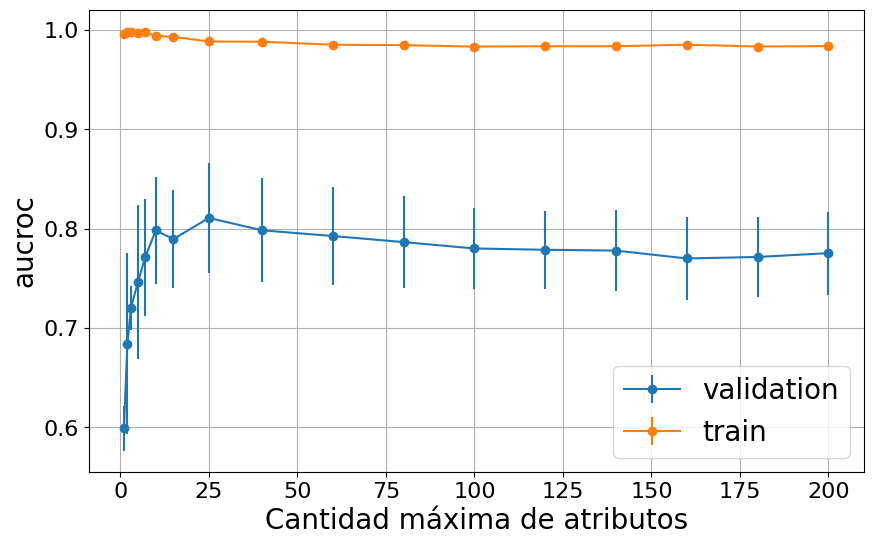

In [4]:
best_params_wo_mf = best_params.copy()
del best_params_wo_mf["max_features"]
k = 5
cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=seed)
fig, ax = plt.subplots(figsize=(10, 6))
mean_val_scores, _, _, _ = complexity_curve(ForestTreeWrapper(**best_params, random_state=seed),
                 "max_features",
                 [1, 2, 3, 5, 7, 10, 15, 25, 40, 60, 80, 100, 120, 140, 160, 180, 200],
                 X_train,
                 y_train,
                 aucroc,
                 True,
                 cv,
                 ax)
ax.legend(fontsize=20)
ax.set_xlabel('Cantidad máxima de atributos', fontsize=20)
ax.set_ylabel('aucroc', fontsize=20)
ax.tick_params(axis="x", labelsize=16)
ax.tick_params(axis="y", labelsize=16)
ax.grid(True)

In [5]:
max(mean_val_scores)

0.8107783694086326

### Curva de aprendizaje

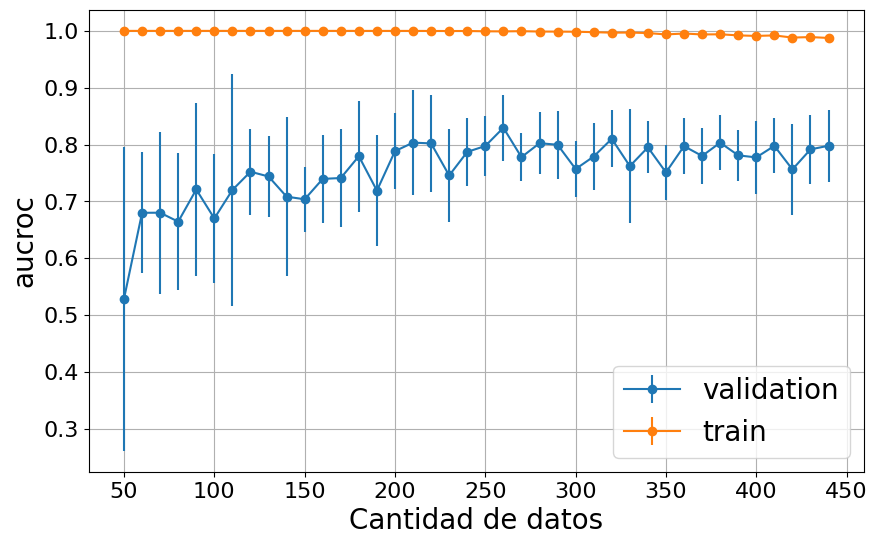

In [6]:
k = 5
n = X_train.shape[0]
cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=seed)
fig, ax = plt.subplots(figsize=(10, 6))
train = range(50, n, 10)
mean_val_scores, _, _, _ = learning_curve(ForestTreeWrapper(**best_params, random_state=seed),
                 train,
                 X_train,
                 y_train,
                 aucroc,
                 True,
                 cv,
                 ax)
ax.legend(fontsize=20, loc='lower right')
ax.set_xlabel('Cantidad de datos', fontsize=20)
ax.set_ylabel('aucroc', fontsize=20)
ax.tick_params(axis="x", labelsize=16)
ax.tick_params(axis="y", labelsize=16)
ax.grid(True)